# Практическая работа №3
## Цель:
изучение архитектур сверточных нейронных сетей для решения задачи сегментации; создание и исследование моделей сверточных нейронных сетей для задачи сегментации.

## Задание:
построить нейронную сеть для выделение родинок на фотографии. Необходимо взять датасет из файла PH2 Dataset images.zip. Необходимо взять файлы из папок "*._Dermoscopic_Image" и маски из папок "*_lesion".

Шаги для выполнения практической работы:
Разбить выборку на тренировочную, валидационную и тестирующую выборку в случайном порядке.
Выбрать три U-net-подобные архитектуры нейронных сетей.
Обучить ИНС. Если сеть начала переобучаться, то или упростить модель, или применить регуляризацию, или использовать dropout, или делать аугментацию, или использовать раннюю остановку. Переобучение можно заметить по потерям на валидационном множестве.
Запустить модели на тестирующей выборке и посчитать их IoU и Dice.

In [2]:
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = (15,4)

C:\Users\yormu\AppData\Local\Temp\ipykernel_15028\2689955696.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
images = []
masks = []

root = "PH2 Dataset"

for root, dirs, files in os.walk("PH2 Dataset"):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        masks.append(imread(os.path.join(root, files[0])))

In [2]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [3]:
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
from torch.utils.data import DataLoader

def create_dataloader(X, Y, batch_size):
    ix = np.random.choice(len(X), len(X), False)
    tr, val, ts = np.split(ix, [100, 150])
    batch_size = batch_size
    data_train = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                         batch_size=batch_size, shuffle=True)
    data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                          batch_size=batch_size, shuffle=True)
    data_test = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                         batch_size=batch_size, shuffle=True)
    
    return data_train, data_val, data_test

In [7]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    return iou

In [9]:
def dice_loss(y_pred, y_real):
    y_pred = torch.clip(y_pred, 1e-7, 1 - 1e-7)
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    num = (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 2 * (num) / (den)
    
    return res

In [10]:
def train(model, opt, loss_fn, epochs, data_train, data_val):
    train_loss = []
    eval_loss = []
    iou_scores = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_train:
            opt.zero_grad()
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss.detach().cpu() / len(data_train)
        train_loss.append(avg_loss.item())
        model.eval()
        avg_val_loss = 0
        iou_score = 0
        with torch.no_grad():
            for X_val, Y_val in data_val:
                Y_pred = model(X_val)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred[Y_pred > 0.5] = 1
                loss = loss_fn(Y_pred, Y_val)
                avg_val_loss += loss.detach().cpu() / len(data_val)
                iou_score += iou_pytorch(Y_pred, Y_val).mean().detach().cpu() / len(data_val)
            eval_loss.append(avg_val_loss.item())
            iou_scores.append(iou_score.item())

    return train_loss, eval_loss, iou_scores

In [11]:
def score_model(model, metric, data):

    with torch.no_grad():
        model.eval()
        scores = 0

        for X_batch, Y_label in data:
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred[Y_pred > 0.5] = 1
            scores += (metric(Y_pred, Y_label).mean().item())

    return scores / len(data)

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        ) 
        self.pool0 = nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)


        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )


        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)

        btnck = self.bottleneck_conv(pool3)

        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc3)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc2)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc1)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc0)

        return dec3

In [14]:
data_train, data_val, data_test = create_dataloader(X, Y, 10)
max_epochs = 20
unet = UNet()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)
unet_train_loss, unet_eval_loss, unet_iou_score = train(unet, optimizer,
                                                                       dice_loss, max_epochs, data_train, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet_train_loss"] = unet_train_loss
train_results["unet_eval_loss"] = unet_eval_loss
train_results["unet_iou_score"] = unet_iou_score
train_results.to_csv("train_results.csv")

* Epoch 1/20
* Epoch 2/20
* Epoch 3/20
* Epoch 4/20
* Epoch 5/20
* Epoch 6/20
* Epoch 7/20
* Epoch 8/20
* Epoch 9/20
* Epoch 10/20
* Epoch 11/20
* Epoch 12/20
* Epoch 13/20
* Epoch 14/20
* Epoch 15/20
* Epoch 16/20
* Epoch 17/20
* Epoch 18/20
* Epoch 19/20
* Epoch 20/20


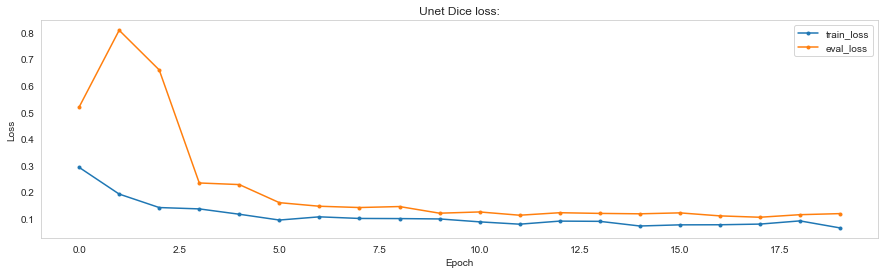

In [15]:
plt.title("Unet Dice loss:")
plt.plot(unet_train_loss, label="train_loss", marker=".")
plt.plot(unet_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [31]:
unet_test_score = score_model(unet, iou_pytorch, data_test)
scores_results = pd.read_csv("scores_results.csv")
scores_results["unet_test_score"] = [unet_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet IoU score: ", unet_test_score)

Unet IoU score:  0.875523054599762


In [32]:
unet_test_dice_score = 1 - score_model(unet, dice_loss, data_test)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_test_dice_score"] = [unet_test_dice_score]
scores_results.to_csv("scores_results.csv")
print("Unet Dice score: ", unet_test_dice_score)

Unet Dice score:  0.9316155433654785


In [17]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool0 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=2)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=2)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=2)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=2)

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )

        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)

        btnck = self.bottleneck_conv(pool3)

        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc3)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc2)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc1)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc0)

        return dec3

In [18]:
data_train, data_val, data_test = create_dataloader(X, Y, 10)
unet2 = UNet2()
max_epochs = 20
optimizer = optim.Adam(unet2.parameters(), lr=0.0001)
unet2_train_loss, unet2_eval_loss, unet2_iou_score = train(unet2, optimizer,
                                                  dice_loss, max_epochs, data_train, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet2_train_loss"] = unet2_train_loss
train_results["unet2_eval_loss"] = unet2_eval_loss
train_results["unet2_iou_score"] = unet2_iou_score
train_results.to_csv("train_results.csv")

* Epoch 1/20
* Epoch 2/20
* Epoch 3/20
* Epoch 4/20
* Epoch 5/20
* Epoch 6/20
* Epoch 7/20
* Epoch 8/20
* Epoch 9/20
* Epoch 10/20
* Epoch 11/20
* Epoch 12/20
* Epoch 13/20
* Epoch 14/20
* Epoch 15/20
* Epoch 16/20
* Epoch 17/20
* Epoch 18/20
* Epoch 19/20
* Epoch 20/20


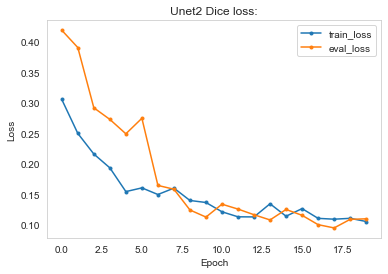

In [13]:
plt.title("Unet2 Dice loss:")
plt.plot(unet2_train_loss, label="train_loss", marker=".")
plt.plot(unet2_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [28]:
unet2_test_score = score_model(unet2, iou_pytorch, data_test)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_test_score"] = [unet2_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet2 IoU score: ", unet2_test_score)

Unet2 IoU score:  0.8322235465049743


In [30]:
unet2_test_dice_score = 1 - score_model(unet2, dice_loss, data_test)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_test_dice_score"] = [unet2_test_dice_score]
scores_results.to_csv("scores_results.csv")
print("Unet2 Dice score: ", unet2_test_dice_score)

Unet2 Dice score:  0.9096129536628723


In [13]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2048),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)


        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2048),
            nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2048),
        )

        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )

        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample4 = nn.Upsample(scale_factor=2)
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)
        enc4 = self.enc_conv4(pool3)
        pool4 = self.pool4(enc4)

        btnck = self.bottleneck_conv(pool4)

        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc4)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc3)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc2)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc1)
        upsamp4 = self.upsample4(dec3)
        dec4 = self.dec_conv4(upsamp4 + enc0)

        return dec4

In [14]:
data_train, data_val, data_test = create_dataloader(X, Y, 10)
unet3 = UNet3()
max_epochs = 20
optimizer = optim.Adam(unet3.parameters(), lr=0.0001)
unet3_train_loss, unet3_eval_loss, unet3_iou_score = train(unet3, optimizer,
                                                  dice_loss, max_epochs, data_train, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet3_train_loss"] = unet3_train_loss
train_results["unet3_eval_loss"] = unet3_eval_loss
train_results["unet3_iou_score"] = unet3_iou_score
train_results.to_csv("train_results.csv")

* Epoch 1/20
* Epoch 2/20
* Epoch 3/20
* Epoch 4/20
* Epoch 5/20
* Epoch 6/20
* Epoch 7/20
* Epoch 8/20
* Epoch 9/20
* Epoch 10/20
* Epoch 11/20
* Epoch 12/20
* Epoch 13/20
* Epoch 14/20
* Epoch 15/20
* Epoch 16/20
* Epoch 17/20
* Epoch 18/20
* Epoch 19/20
* Epoch 20/20


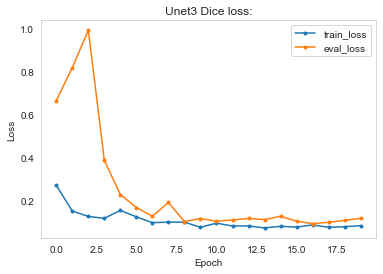

In [12]:
plt.title("Unet3 Dice loss:")
plt.plot(unet3_train_loss, label="train_loss", marker=".")
plt.plot(unet3_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [16]:
unet3_test_score = score_model(unet3, iou_pytorch, data_test)
scores_results = pd.read_csv("scores_results.csv")
scores_results["unet3_test_score"] = [unet3_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet3 IoU score: ", unet3_test_score)

Unet3 IoU score:  0.8313583374023438


In [17]:
unet3_test_dice_score = 1 - score_model(unet3, dice_loss, data_test)
scores_results = pd.read_csv("scores_results.csv")
scores_results["unet3_test_dice_score"] = [unet3_test_dice_score]
scores_results.to_csv("scores_results.csv")
print("Unet3 Dice score: ", unet3_test_dice_score)

Unet3 Dice score:  0.8775076389312744


In [3]:
train_results = pd.read_csv("train_results.csv")

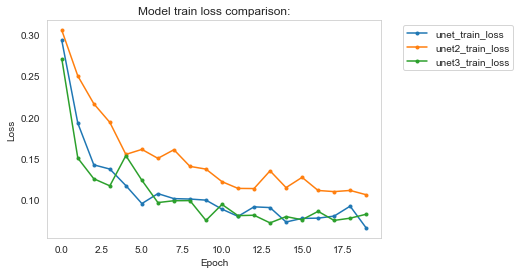

In [11]:
unet_train_loss = train_results["unet_train_loss"]
unet2_train_loss = train_results["unet2_train_loss"]
unet3_train_loss = train_results["unet3_train_loss"]

train_losses = {
                "unet_train_loss" : unet_train_loss,
                "unet2_train_loss" : unet2_train_loss,
                "unet3_train_loss" : unet3_train_loss,
               }

for key, val in train_losses.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model train loss comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

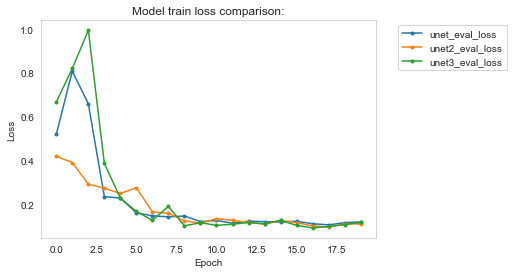

In [6]:
unet_eval_loss = train_results["unet_eval_loss"]
unet2_eval_loss = train_results["unet2_eval_loss"]
unet3_eval_loss = train_results["unet3_eval_loss"]

train_losses = {
                "unet_eval_loss" : unet_eval_loss,
                "unet2_eval_loss" : unet2_eval_loss,
                "unet3_eval_loss" : unet3_eval_loss,
               }

for key, val in train_losses.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model train loss comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

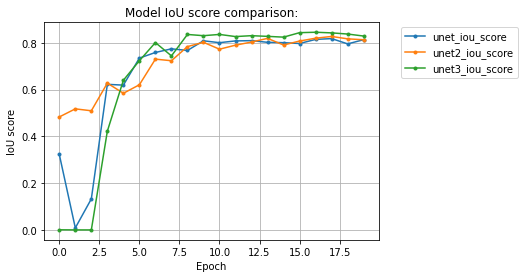

In [4]:
unet_iou_score = train_results["unet_iou_score"]
unet2_iou_score = train_results["unet2_iou_score"]
unet3_iou_score = train_results["unet3_iou_score"]

train_losses = {
                "unet_iou_score" : unet_iou_score,
                "unet2_iou_score" : unet2_iou_score,
                "unet3_iou_score" : unet3_iou_score,
               }

for key, val in train_losses.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model IoU score comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("IoU score")
plt.show()